In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.datasets import make_classification
import warnings
from IPython.display import display
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

# Features pre-processing and principal component analysis (pca)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Train-test split
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Classifiers ensembling
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

# Other
from time import time
from scipy.stats import ttest_ind

# Ploting
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format

from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


# Suppressing annoying harmless error
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
warnings.simplefilter('ignore')

# ROC-AUC Calculation modules

In [4]:
# Read the data from the local drive

safe_driver = pd.read_csv('IT_3.csv')

In [6]:
# Check if there are any NULL data that need to be dropped
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            30240 non-null  int64  
 1   target                        30240 non-null  int64  
 2   Gender                        30240 non-null  object 
 3   EngineHP                      30240 non-null  int64  
 4   credit_history                30240 non-null  int64  
 5   Years_Experience              30240 non-null  int64  
 6   annual_claims                 30240 non-null  int64  
 7   Marital_Status                30240 non-null  object 
 8   Vehical_type                  30240 non-null  object 
 9   Miles_driven_annually         30232 non-null  float64
 10  size_of_family                30240 non-null  int64  
 11  Age_bucket                    30240 non-null  object 
 12  EngineHP_bucket               30240 non-null  object 
 13  Y

In [7]:
safe_driver.describe()

,ID,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
count,30240.000,30240.000,30240.000,30240.000,30240.000,30240.000,30232.000,30240.000
mean,15120.500,0.708,196.604,685.770,13.256,1.138,17422.939,4.521
std,8729.680,0.455,132.347,102.454,9.890,1.083,17483.783,2.287
min,1.000,0.000,80.000,300.000,1.000,0.000,5000.000,1.000
25%,7560.750,0.000,111.000,668.000,5.000,0.000,9668.500,3.000
50%,15120.500,1.000,141.000,705.000,10.000,1.000,12280.000,5.000
75%,22680.250,1.000,238.000,753.000,20.000,2.000,14697.250,7.000
max,30240.000,1.000,1005.000,850.000,40.000,4.000,99943.000,8.000


In [8]:
from scipy import stats
x, _ = stats.boxcox(safe_driver['credit_history'])

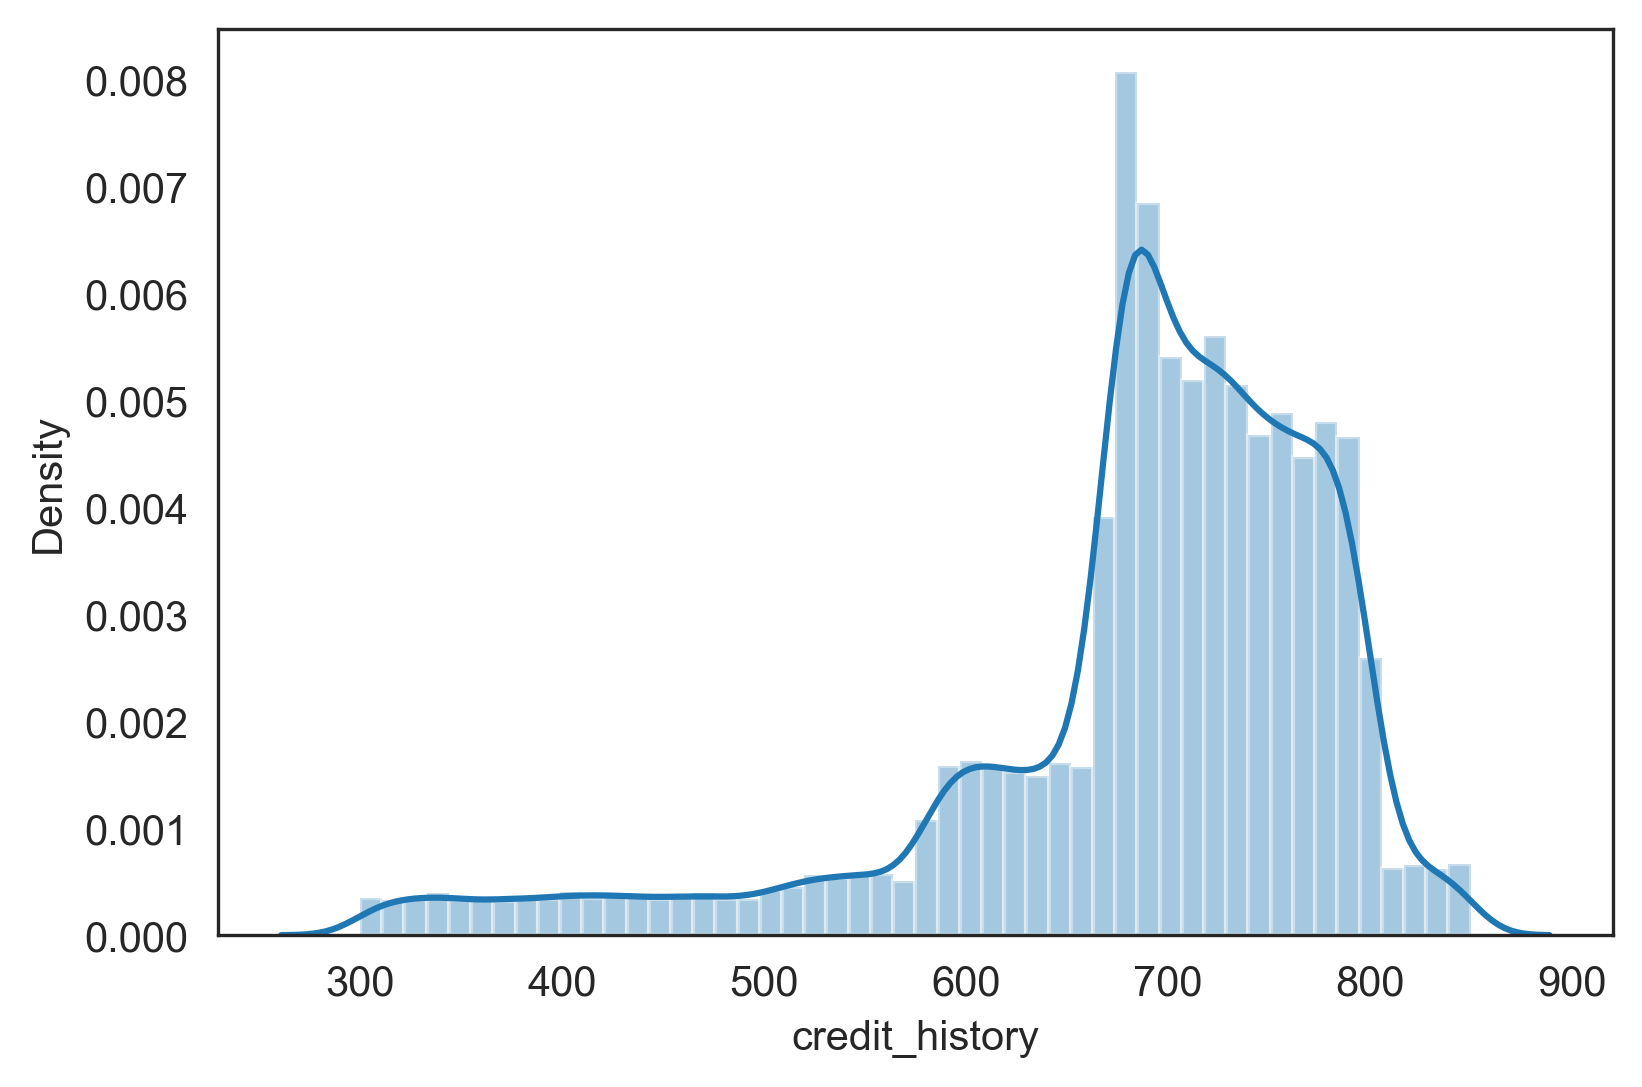

In [9]:
ax = sns.distplot(safe_driver.credit_history)

In [10]:
# Check and see if we have an imbalanced class label in the dataset
# Calculate the percentage of success data ('target' == 1) with respect to the failure data ('target' == 0)

true_claims = (safe_driver['target'] == 1).sum()
print('True Claims is  {}'.format(true_claims))

total_records = len(safe_driver['target'])
print('Total number of records is {}'.format(total_records))

print('The percentage of true claims is {}%'.format(
    round(true_claims / total_records * 100), 2))

True Claims is  21396
Total number of records is 30240
The percentage of true claims is 71%


Our dataset is indeed imbalanced. We will balance it later using SMOTE technique.

The dataset contains several categorical data that ends with `_bucket` that need to be either dropped or converted to numerical values using dummies. All features that are of type object are categorical variables that needs to either:<br>
<br>
a. Converted to numeric using dummies<br>
b. Dropped or<br>
c. Assigned a binary value<br>

In [11]:
cat_features = safe_driver.select_dtypes(include=['object']).copy()
print(cat_features.columns)

Index(['Gender', 'Marital_Status', 'Vehical_type', 'Age_bucket',
       'EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket', 'State'],
      dtype='object')


Among the categorical variables we retain the following:<br>
<br>
1. Gender<br>
2. Marital_Status<br>
3. Vehicle_Type, and<br>
4. Age_bucket<br>
<br>
EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket have a corresponding continuous variable. Creating each with their own dummies along with the continuous variable does not make sense. We will keep the Age_bucket as there is no continuous variable to represent age.<br>
<br>
We can split the dataset by State (one sub-dataset for each state) and analyze each state by itself. As each US state has its own regulations it may make sense to analyze each state by itself. We could aggregate our results across states later to get a national statistic.<br>
<br>
Or, for now, we could drop the State column and analyze the data across the nation later.

In [12]:
# Drop these 5 columns: ID, EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket

safe_driver.drop(['ID', 'EngineHP_bucket', 'Years_Experience_bucket',
                  'Miles_driven_annually_bucket',
                  'credit_history_bucket'], axis=1, inplace=True)

In [13]:
# Check if the dataset has any NaN values as these values will make our algorithms throw an exception

safe_driver.isnull().sum()

target                   0
Gender                   0
EngineHP                 0
credit_history           0
Years_Experience         0
annual_claims            0
Marital_Status           0
Vehical_type             0
Miles_driven_annually    8
size_of_family           0
Age_bucket               0
State                    0
dtype: int64

The Miles_driven_annually feature has some null values. Let us explore which particular cells have NaN and ingest them with the median data.

In [14]:
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,State
1235,1,F,124,793,27,0,Married,Truck,nan,3,>40,NJ
7365,0,F,465,696,5,0,Married,Truck,nan,8,18-27,SD
11464,1,F,137,787,18,1,Married,Truck,nan,1,>40,CT
18158,0,F,108,747,8,1,Married,Truck,nan,1,18-27,OR
19795,1,F,121,774,19,0,Married,Truck,nan,2,28-34,NY
25731,1,F,355,694,15,1,Married,Truck,nan,5,28-34,CT
26512,1,F,109,743,40,0,Married,Truck,nan,1,>40,OR
27045,1,F,83,784,21,0,Married,Truck,nan,1,>40,CT


It may make sense to ingest the median of  `Vehicle_Type=='Truck'` as all the NaN values are for Truck only. Let us look at the median of Miles_driven_annually by each vehicle type. 

In [16]:
median_values = safe_driver.groupby('Vehical_type').median()
median_values

,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
Vehical_type,,,,,,,
Car,1,148,695,7,1,13147.500,4
Truck,1,150,694,8,1,12370.500,5
Utility,1,132,741,14,1,11117.000,5
Van,1,128,721,15,1,11272.000,5


In [17]:
# Replace NaN values in Miles_driven_annually with the median value for Truck
# There may be better ways to impute missing data. But we have just 8 NaN cells out of some 30,000+ rows which is
# less than 0.03%
# So, imputing with median for all the 8 cells is not going to skew our results.

safe_driver.fillna(
    median_values.loc['Truck', 'Miles_driven_annually'], inplace=True)

In [18]:
# Check for null values again to make sure we did not miss any accidentally

safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,State


In [19]:
# Check the data types of all remaining features

safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 30240 non-null  int64  
 1   Gender                 30240 non-null  object 
 2   EngineHP               30240 non-null  int64  
 3   credit_history         30240 non-null  int64  
 4   Years_Experience       30240 non-null  int64  
 5   annual_claims          30240 non-null  int64  
 6   Marital_Status         30240 non-null  object 
 7   Vehical_type           30240 non-null  object 
 8   Miles_driven_annually  30240 non-null  float64
 9   size_of_family         30240 non-null  int64  
 10  Age_bucket             30240 non-null  object 
 11  State                  30240 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.8+ MB


Looking at the feature values above, the range of values of each vary a lot. For example `'Miles_driven_annually'` is in the 10s of thousands, whereas 'credit_history' is in the 100s and 'annual-claims' is in single digit. Due to the varying magnitudes of the feature values we will scale the features with Z-scores using `sklearn.preprocessing.scale`.<br>
<br>

In [20]:
# To standardize the numeric features we need to isolate them first into a separate dataframe

safe_driver_num_features = safe_driver.drop(
    safe_driver.select_dtypes(['object']), axis=1)

# Do not standardize 'target' which is our label

safe_driver_num_features.drop(['target'], axis=1, inplace=True)

safe_driver_cat_features = safe_driver.select_dtypes(['object'])

In [21]:
# Check if there are any NaN values one more time

safe_driver_num_features[safe_driver_num_features.isnull().any(axis=1)]

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family


In [22]:
from sklearn import preprocessing

# Restore the column names from the original dataset

safe_driver_scaled = pd.DataFrame(preprocessing.scale(safe_driver_num_features),
                                  columns=safe_driver_num_features.columns)

# We now have the scaled feature set. Now we need to concatenate the categorical features back with our scaled
# dataset before running OneHotEncoder or dummies.

In [23]:
# We will concatenate the scaled dataframe with the categorical feature set

safe_driver = pd.concat(
    [safe_driver_scaled, safe_driver['target'], safe_driver_cat_features], axis=1)

# We will add the 'target' label back to the scaled dataframe as we may need it later
safe_driver_scaled = pd.concat(
    [safe_driver_scaled, safe_driver['target']], axis=1)

In [24]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,F,Married,Car,<18,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,F,Married,Car,28-34,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,M,Married,Van,>40,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,M,Married,Van,18-27,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,M,Married,Van,>40,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,F,Married,Truck,>40,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,F,Married,Truck,>40,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,F,Single,Car,>40,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,F,Married,Car,>40,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,F,Married,Truck,35-40,NJ


Let us use data visualization techniques to find the distribution of the features and also the correlation between different features. We could, may be, drop one or two more features based on distribution or correlation making our dataset cleaner.

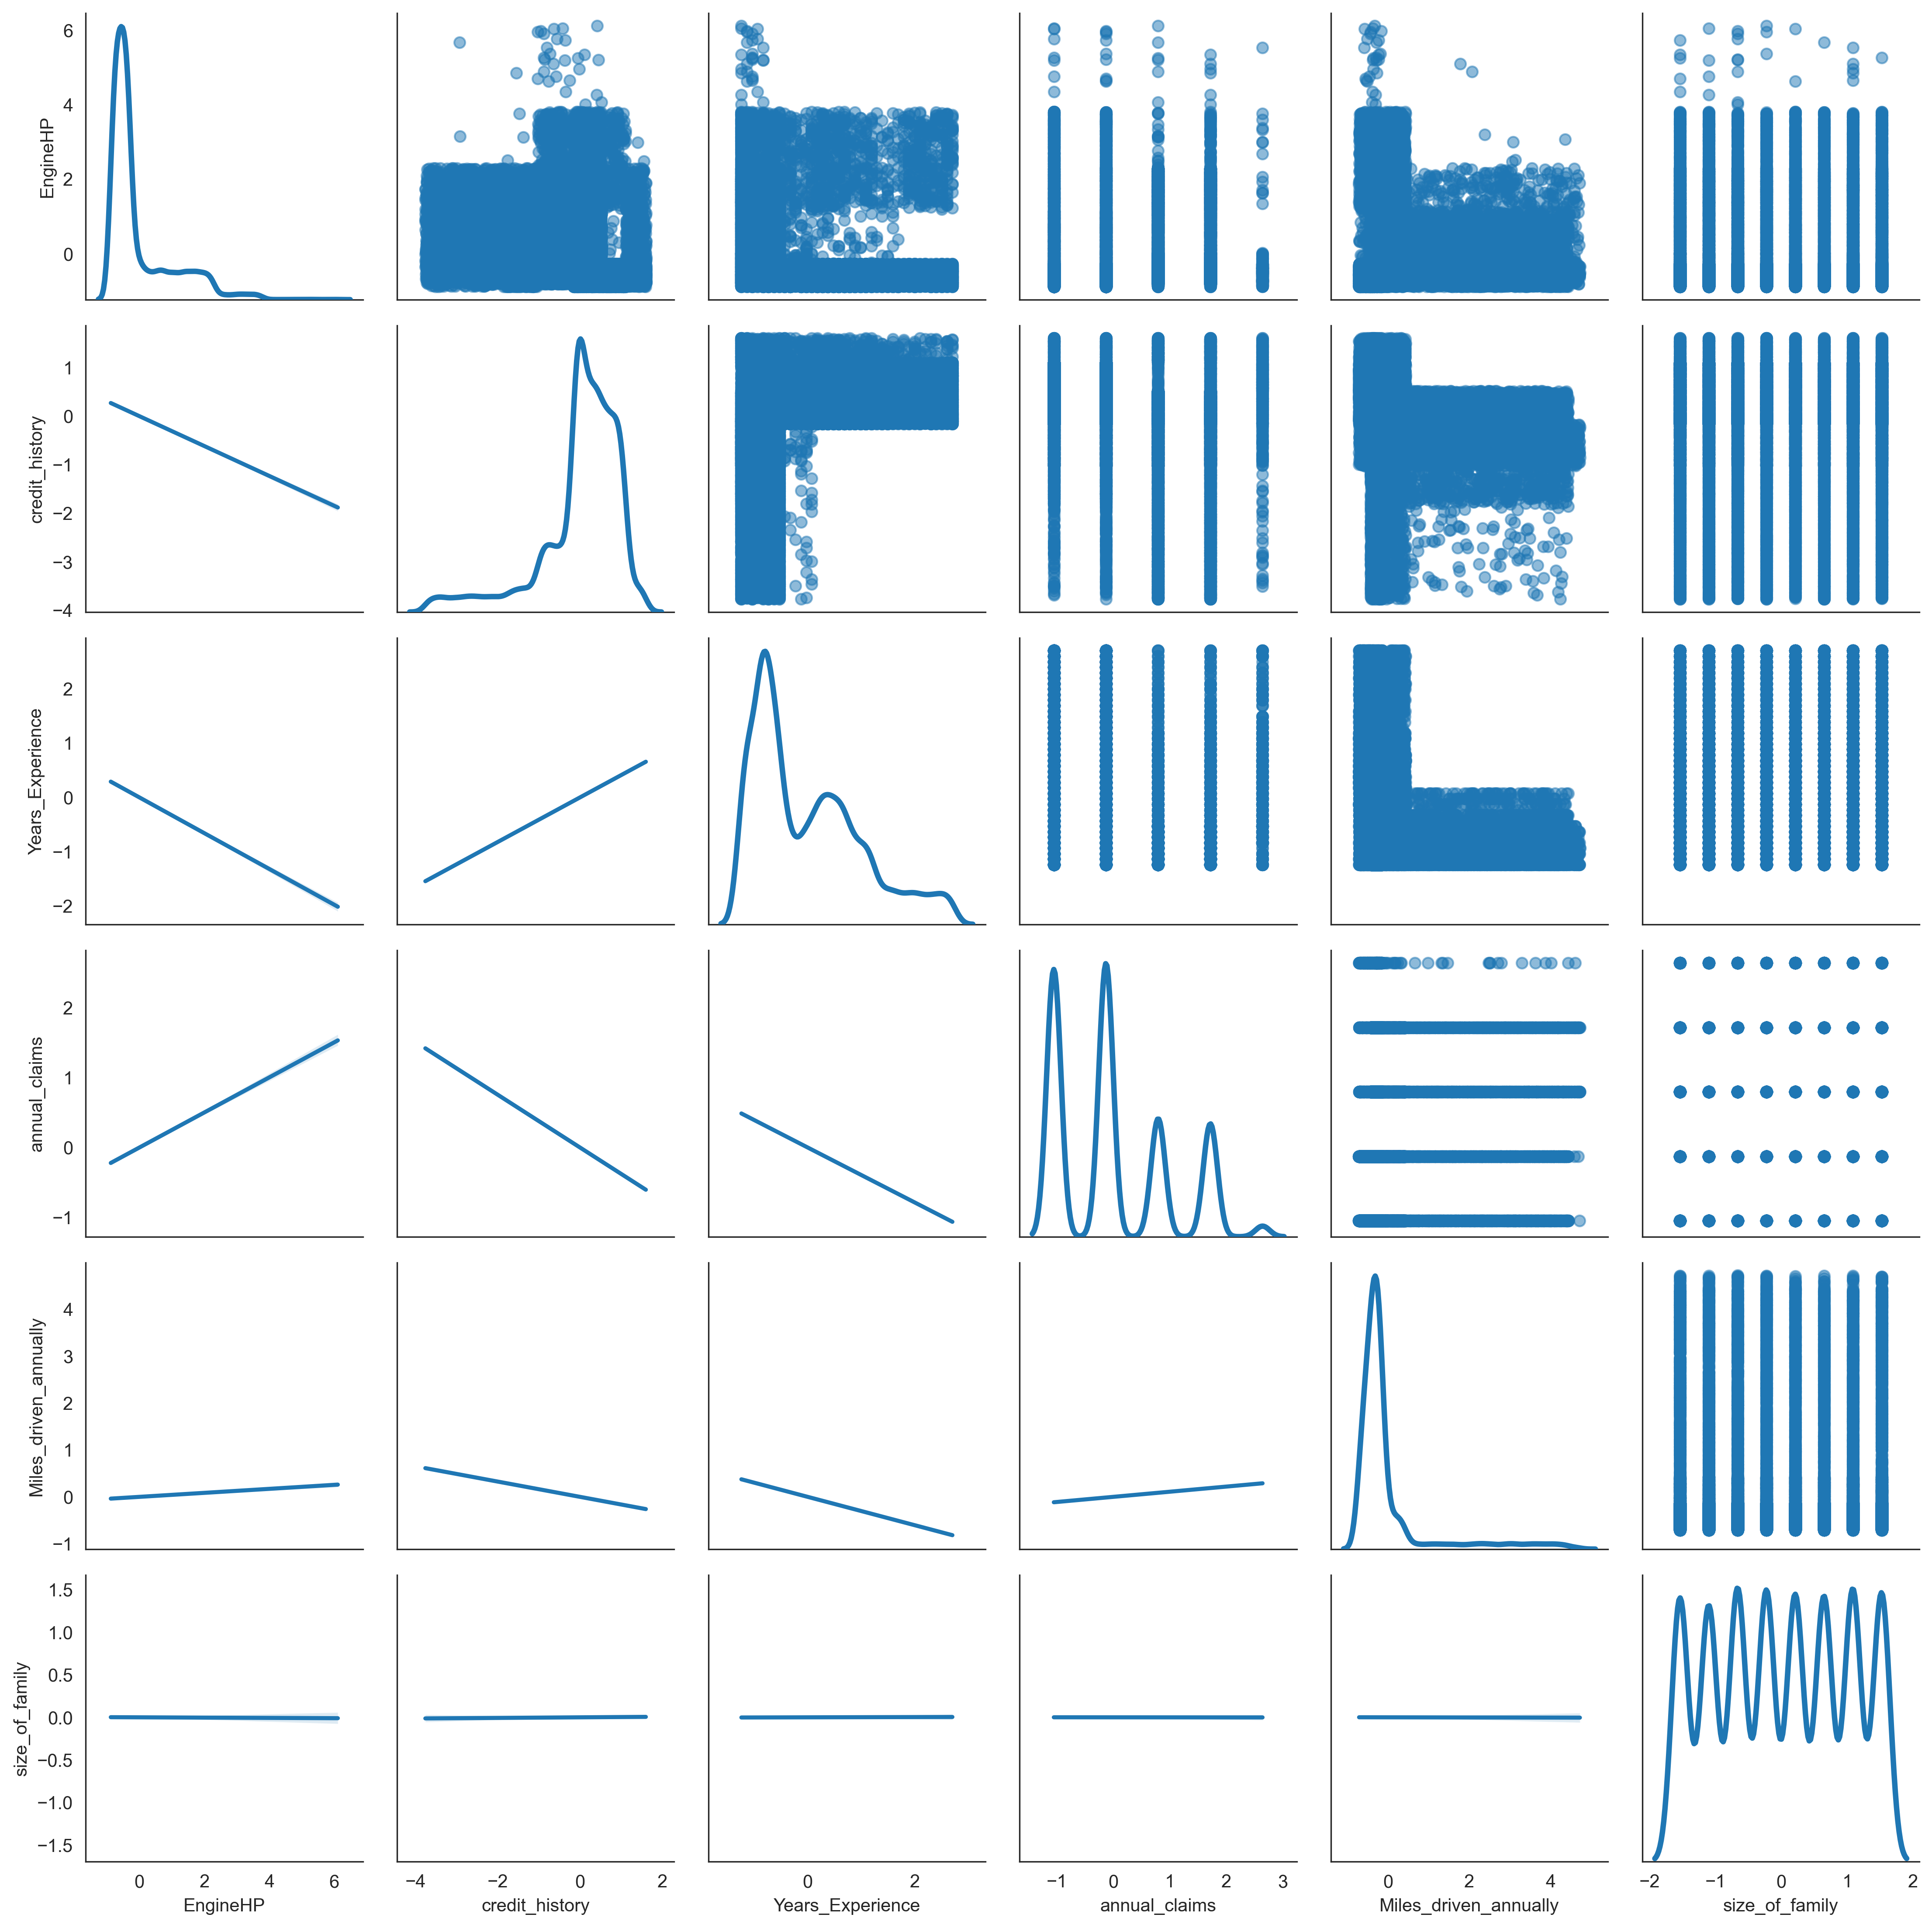

In [25]:
# Create a scatterplot matrix that shows all the bivariate relationships in one plot made up of subplots.
# Let us drop the 'target' variable

safe_driver_copy = safe_driver.drop(['target'], axis=1)

# Plot with the remaining feature set

g = sns.PairGrid(safe_driver_copy.dropna(),
                 diag_sharey=False) #hue='Vehicle_Type')
# As in the Unit 2 lesson example, create a Scatterplot in the top-right diagonal
g.map_upper(plt.scatter, alpha=.5)
# Linear relationship of two variables in the bottom-left diagonal
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# And...univariate distributions of the variables across the diagonal
g.map_diag(sns.kdeplot, lw=3)
#plt.legend()
plt.show()

# The legend appears at the bottom-right plot

Our next step is to output a correlation heatmap that can tell us correlation coefficient of the features. If two variables are highly corrrelated our results could be incorrect or skewed.<br>
<br>
First we have to isolate the continuous variables in a dataframe before invoking the heatmap.<br>
<br>
Let us create the heatmap.

[]

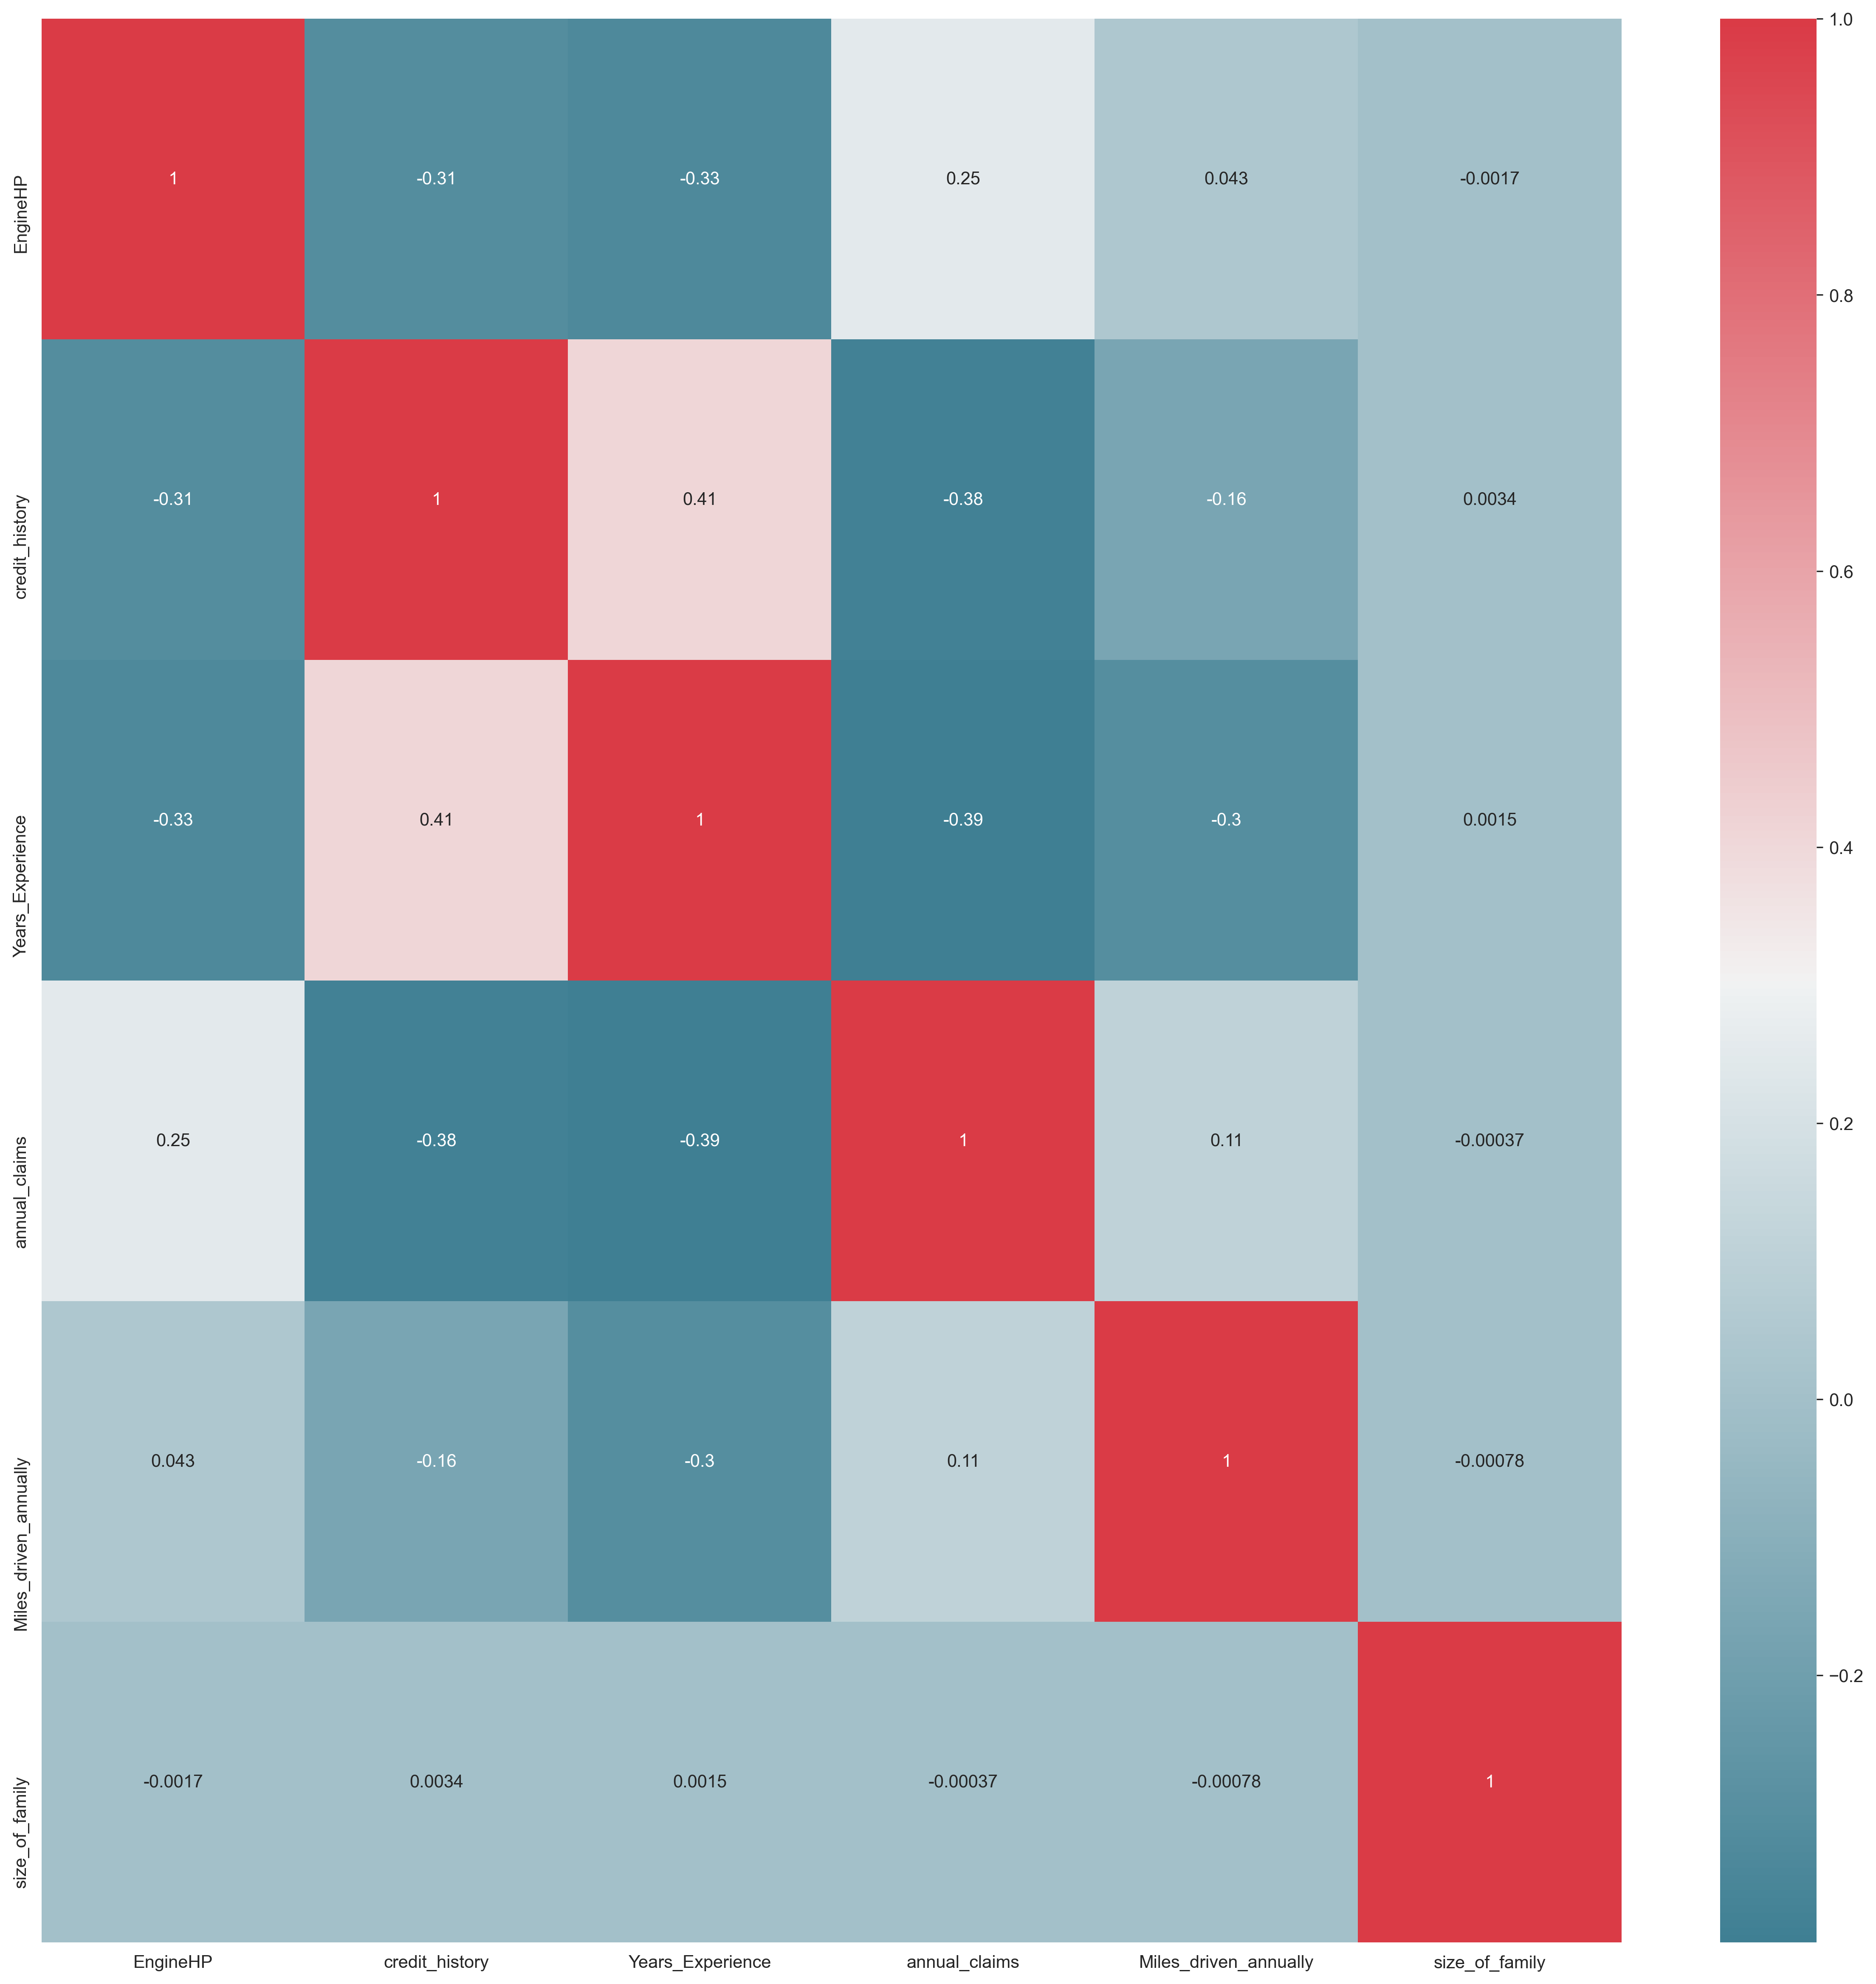

In [26]:
sns.set_style('white')
color_map = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 20))
sns.heatmap(safe_driver_num_features.corr(), annot=True, cmap=color_map)
plt.plot()

The features are not highly correlated with our target variable. We can keep the remaining features as it is.

In [27]:
safe_driver_num_features = pd.concat(
    [safe_driver_num_features, safe_driver['target']], axis=1)

In [28]:
safe_driver_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   EngineHP               30240 non-null  int64  
 1   credit_history         30240 non-null  int64  
 2   Years_Experience       30240 non-null  int64  
 3   annual_claims          30240 non-null  int64  
 4   Miles_driven_annually  30240 non-null  float64
 5   size_of_family         30240 non-null  int64  
 6   target                 30240 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.6 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181440 entries, 0 to 181439
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   target    181440 non-null  int64  
 1   variable  181440 non-null  object 
 2   value     181440 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ MB


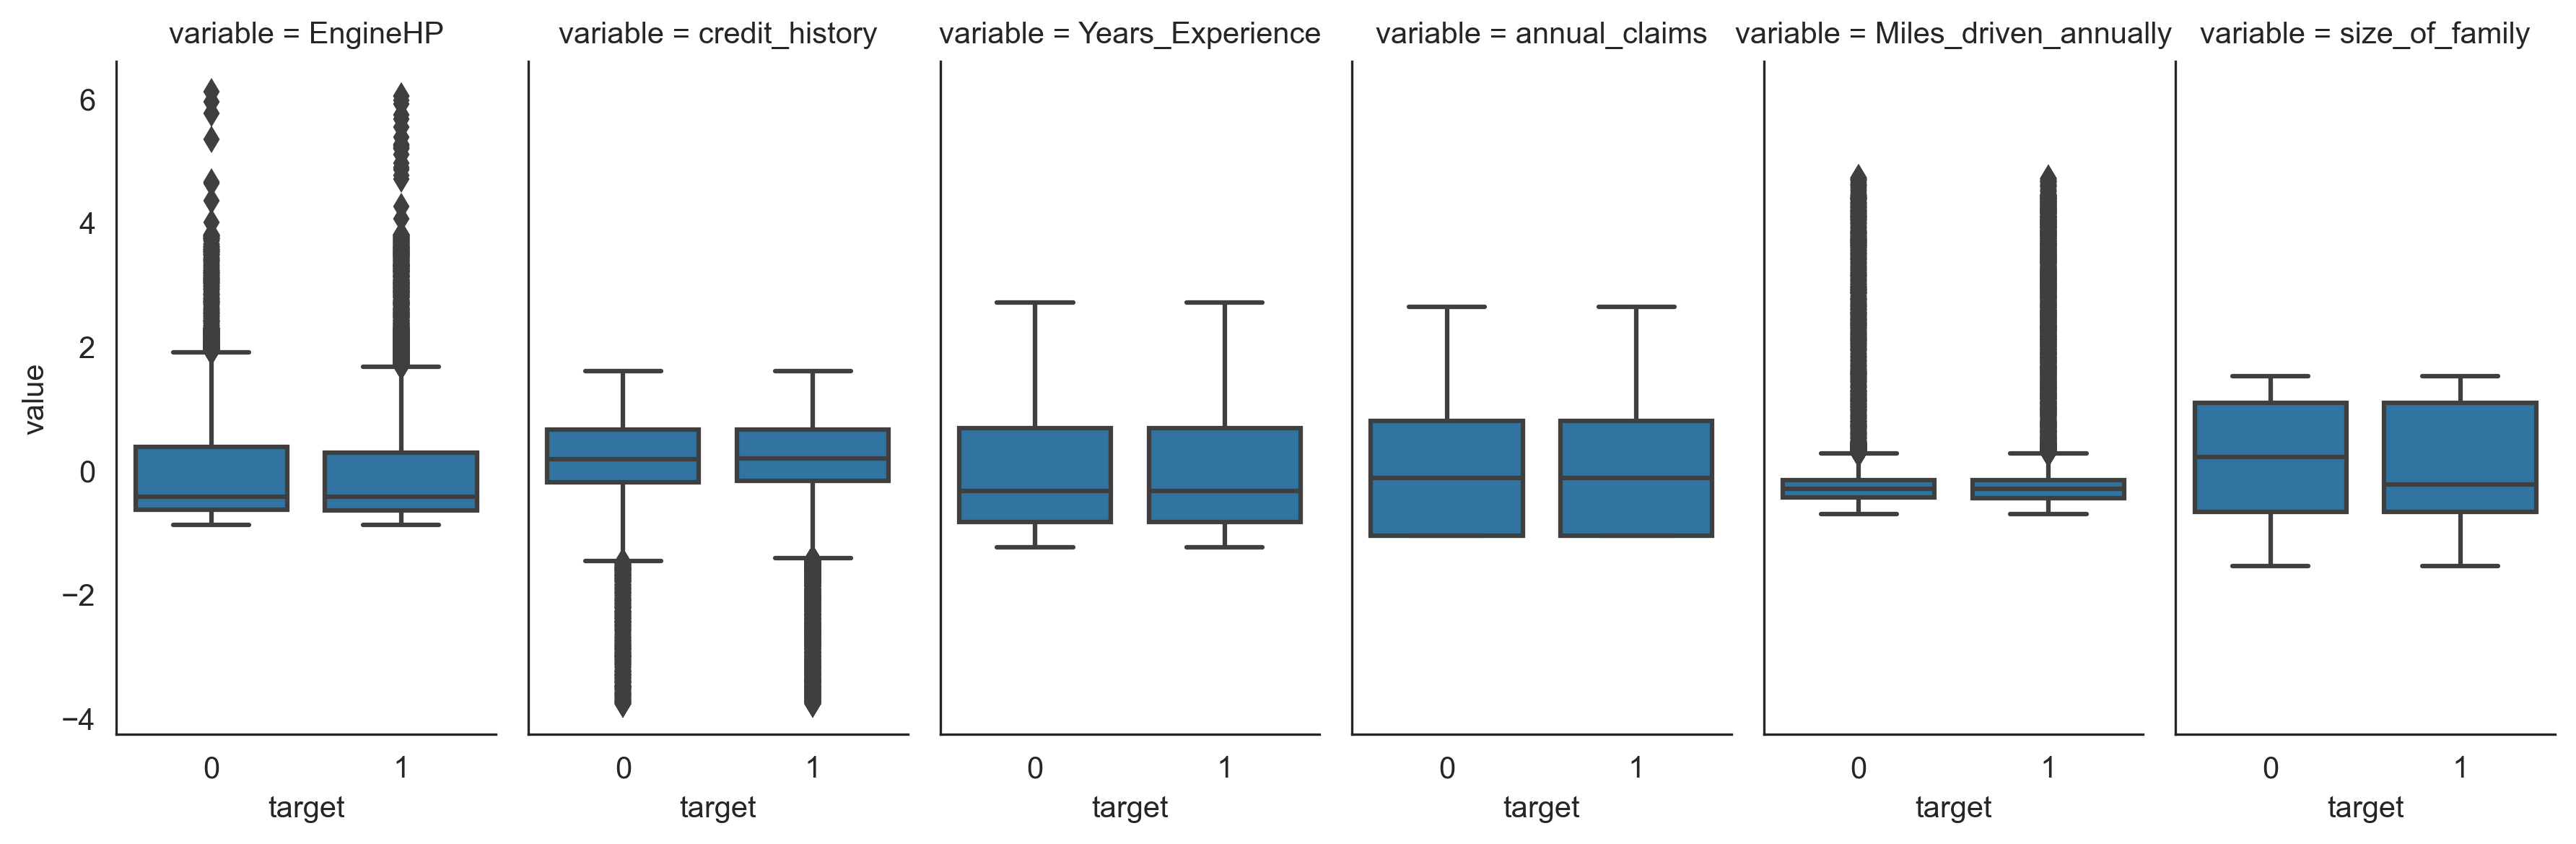

In [29]:
# Let us also look at the relationship between our dependent variable with categorical variables

# Plot all the variables with boxplots for each continuous variable.

# Restructure the data so we can use FacetGrid

safe_driver_melt = pd.melt(safe_driver_scaled, id_vars=['target'])
safe_driver_melt.info()
g = sns.FacetGrid(safe_driver_melt, col='variable', size=4, aspect=.5)
g = g.map(sns.boxplot, "target", "value")

plt.show()

Our boxplots indicate that there are some outliers in EngineHP, credit_history and Miles_driven_annually. But we may need to keep the outliers unless they affect our results and take another look at them later.

Here, below, we separate our feature set from the label `target` and convert all the categorical variables to numeric. Then split the feature set into training and test data sets.

Let us convert some of the categorical features into numeric giving weightage to each variable.<br>
<br>
1. Gender: 1 = Female and 2 = Male<br>
2. Marital_Status: 1 = Single and 2 = Married<br>
3. Vehicle_Type: Use `LabelEncoder`<br>
4. Age_bucket: Use `LabelEncoder`<br>
<br>
We are not using `dummies` or `OneHotEncoder` because these create sparse matrices and increase dimensionality. By giving a 1 or a 2 for say Marital_Status we give higher weightage to `Married` by assigning a value of 2.

In [30]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,F,Married,Car,<18,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,F,Married,Car,28-34,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,M,Married,Van,>40,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,M,Married,Van,18-27,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,M,Married,Van,>40,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,F,Married,Truck,>40,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,F,Married,Truck,>40,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,F,Single,Car,>40,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,F,Married,Car,>40,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,F,Married,Truck,35-40,NJ


In [33]:
# Convert Gender to a 1 or a 2
safe_driver['Gender'] = np.where(safe_driver['Gender'] == 'F', 1, 2)

# Convert Marital_Status to a 1 or a 2
safe_driver['Marital_Status'] = np.where(
    safe_driver['Marital_Status'] == 'Single', 1, 2)

# Convert Vehicle_Type using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(safe_driver['Vehical_type'])

safe_driver['Vehical_type'] = le.transform(safe_driver['Vehical_type'])

# Convert Age_bucket using LabelEncoder
le.fit(safe_driver['Age_bucket'])

safe_driver['Age_bucket'] = le.transform(safe_driver['Age_bucket'])

In [34]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehical_type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,2,2,0,3,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,2,2,0,1,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,2,2,3,4,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,2,2,3,0,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,2,2,3,4,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,2,2,1,4,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,2,2,1,4,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,2,2,0,4,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,2,2,0,4,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,2,2,1,2,NJ


In [35]:
# Drop the 'target' column from training dataframe as that is our label
X = safe_driver.drop(['target', 'State'], 1)

# The 'target' column is our label or outcome that we want to predict
y = safe_driver['target']

# Use pd.dummies to resolve the categorical data (e.g. State) into numerical values
#X = pd.get_dummies(X)

# Drop and NaN values
X = X.dropna(axis=1)

We found out much earlier that our target label is 70% failure (bad driver or `target` == 1) and 30% success (good driver or `target` == 0). Let us do class balancing using SMOTE and see the distribution.<br>

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)

columns = X.columns
os_data_X, os_data_y = os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])

# Split the resulting balanced data set as train and test

X_train, X_test, y_train, y_test = train_test_split(
    os_data_X, os_data_y, test_size=0.3, random_state=0)

# Check the size of our new data
print("length of oversampled data is ", len(os_data_X))
print("Number of negative class in oversampled data",
      len(os_data_y[os_data_y['y'] == 0]))
print("Number of positive class in oversampled data",
      len(os_data_y[os_data_y['y'] == 1]))
print("Proportion of negative class in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 0])/len(os_data_X))
print("Proportion of positive class in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 1])/len(os_data_X))

Let us find out how significant are our features are in predicting our label. We will use the feature_importances_ method from the RandomForestClassifier. After that we plot the relative importance of the features using a barplot.<br>
<br>
Let us go ahead and select our categorical features, using a RandomForestClassifier.

In [36]:
# Find out the feature importance using RandomForest

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=12)
regr.fit(X, y)

# The features identified by RandomForest will be our columns for the training and testing dataset

feature_importances = pd.DataFrame(regr.feature_importances_, index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                       importance
credit_history              0.378
Miles_driven_annually       0.329
EngineHP                    0.221
Years_Experience            0.059
Age_bucket                  0.013
annual_claims               0.000
size_of_family              0.000
Gender                      0.000
Marital_Status              0.000
Vehical_type                0.000


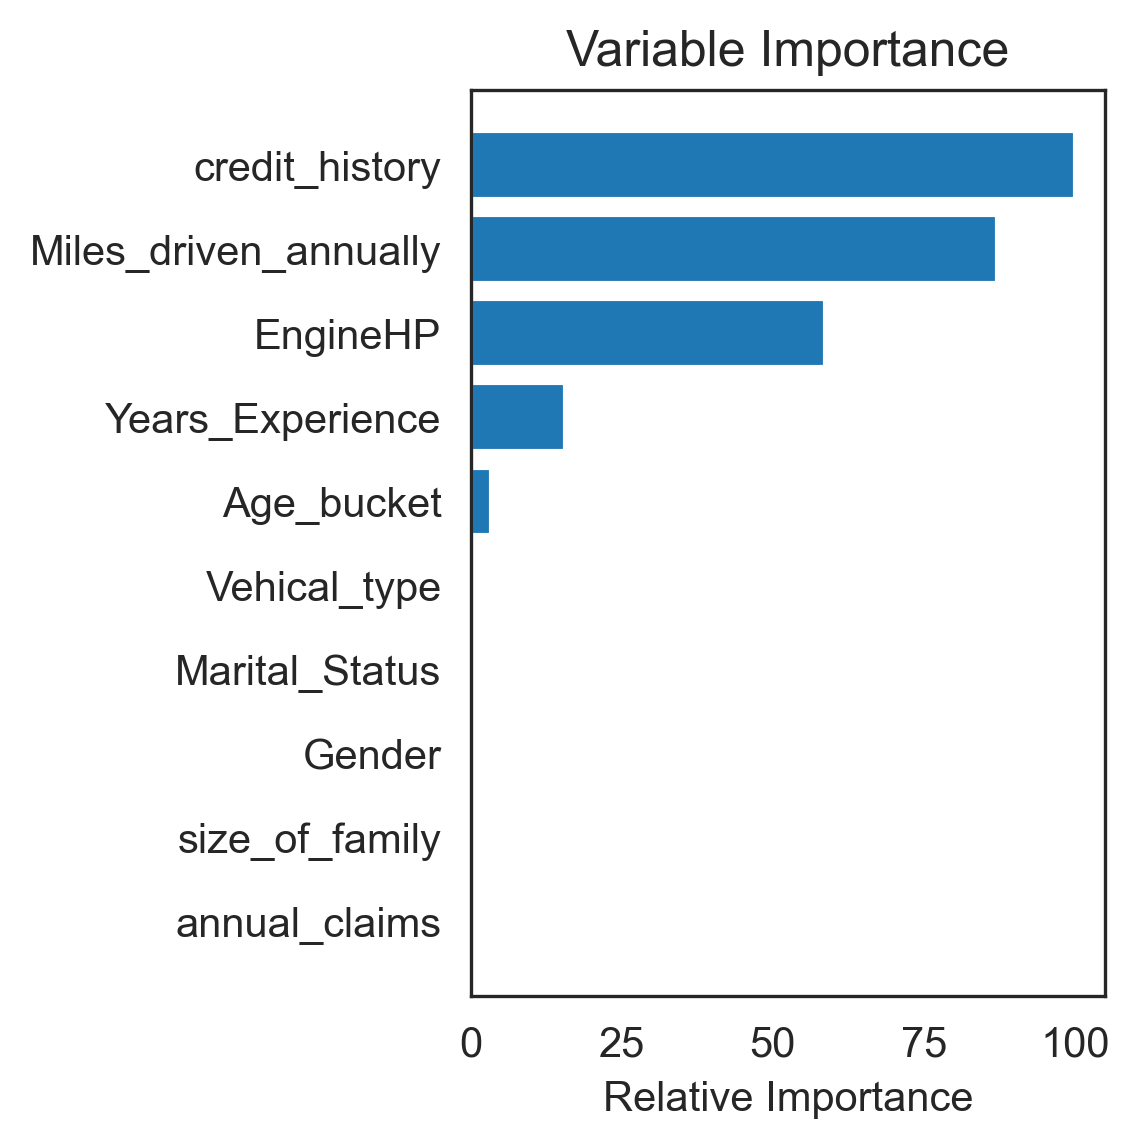

In [37]:
feature_importance = regr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<h2>Decision Tree Classifier</h2>

In [40]:
# Run LogisticRgression model on the training data set

from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_predict = tree.predict(X_test)
tree.score(X_test, y_test)

dt_train_scores = cross_val_score(
    estimator=tree, X=X_train, y=y_train, cv=5, n_jobs=4)
dt_test_scores = cross_val_score(
    estimator=tree, X=X_test, y=y_predict, cv=5, n_jobs=4)

In [41]:
# Print the Accuracy, Error, Sensitivity and Specificity from the returned results
target_names = ['Safe Driver', 'Non-safe Driver']
decision_tree = classification_report(
    y_test, y_predict, target_names=target_names, output_dict=True)

In [42]:
# Print confusion matrix for DecisionTreeClassifier
confusion_matrix(y_test, y_predict)

array([[ 582, 1185],
       [1325, 2956]], dtype=int64)

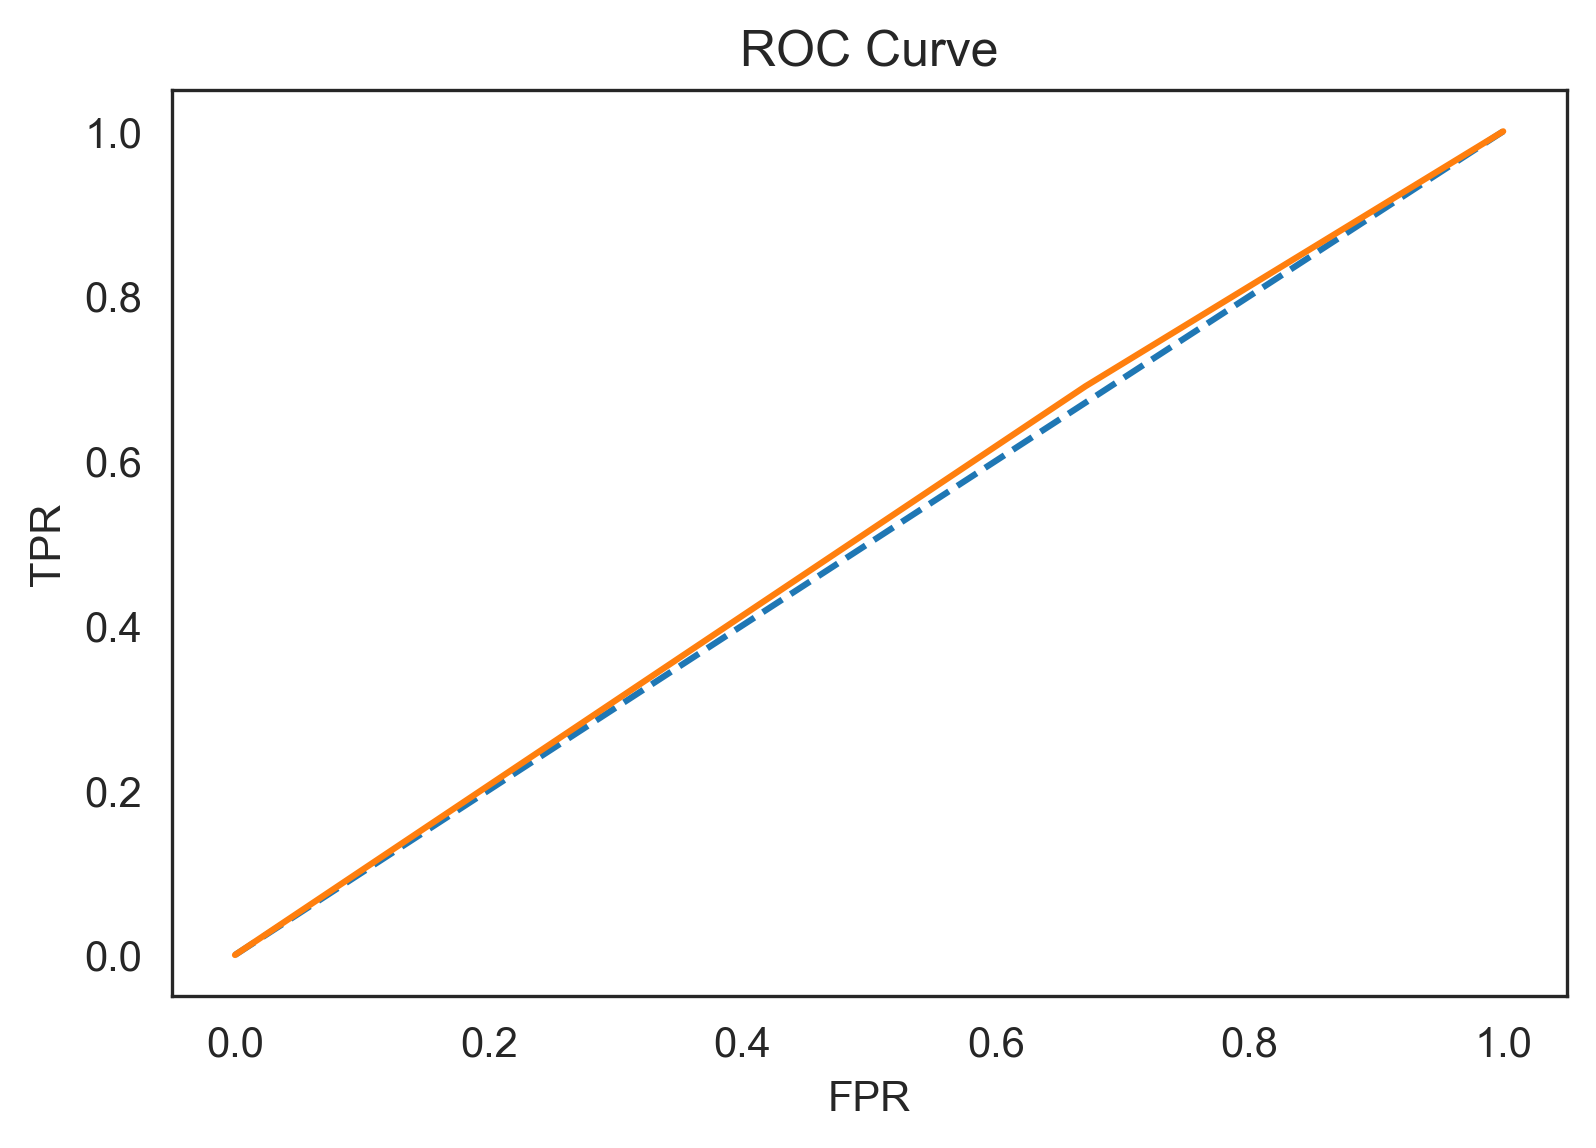

0.5099323460673748


In [43]:
probs = tree.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
# show the plot
plt.show()

auc = roc_auc_score(y_test, probs)
print(auc)

Our confusion matrix based on the DecisionTree does not look good. It is showing a high number of
false positives and false negatives

<h2>Support Vector Classifier</h2>

In [ ]:
# Run Support Vector Classifier to verify accuracy

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svc = SVC(gamma='auto', probability=True)

svc.fit(X_train, y_train)

y_predict = svc.predict(X_train)

svc.score(X_test, y_test)

svc_train_score = cross_val_score(svc, X_train, y_train, cv=5)
svc_test_score = cross_val_score(svc, X_test, y_test, cv=5)

In [ ]:
print(svc_train_score)
print(svc_test_score)

In [ ]:
probs = svc.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
# show the plot
plt.show()

auc = roc_auc_score(y_test, probs)
print(auc)

In [ ]:
target_names = ['Safe Driver', 'Non-safe Driver']
svc_scores = classification_report(
    y_train, y_predict, target_names=target_names, output_dict=True)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_predict)

The SVM Classifier returns less than better results than the DecisionTree model.<br>
<br>
We will try the SGDClassifier.

<h2>Stochastic Gradient Descent Classifier</h2>

In [ ]:
# Let us also run the SGDClassifier model to verify

from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-3)
clf.fit(X_train, y_train)

y_predict_SGD = clf.predict(X_train)

clf.score(X_train, y_train)

In [ ]:
sgd_train_score = cross_val_score(clf, X_train, y_train, cv=5)
sgd_test_score = cross_val_score(clf, X_test, y_test, cv=5)
print(sgd_train_score)
print(sgd_test_score)

In [ ]:
# Function to calculate Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
sgd_scores = classification_report(
    y_train, y_predict, target_names=target_names, output_dict=True)

In [ ]:
confusion_matrix(y_train, y_predict_SGD)

<h2>Support Vector Classifier with different tuning parameters</h2>

Trying SVC again with better tuning parameters found out from StackOverflow.

In [ ]:
from sklearn.svm import SVC

classifier = SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
                 decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
                 max_iter=-1, probability=False, random_state=None, shrinking=True,
                 tol=0.001, verbose=False)

classifier = classifier.fit(X_train, y_train)

y_predict = classifier.predict(X_train)

In [ ]:
svc_2_train_score = cross_val_score(classifier, X_train, y_train, cv=5)
svc_2_test_score = cross_val_score(classifier, X_test, y_test, cv=5)
print(svc_2_train_score)
print(svc_2_test_score)

In [ ]:
confusion_matrix(y_train, y_predict)

In [ ]:
# Print the Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
svc_2_scores = classification_report(
    y_train, y_predict, target_names=target_names, output_dict=True)

<h2>Ridge Classifier</h2>

In [ ]:
# Let us run RidgeClassifier to check results

from sklearn.linear_model import RidgeClassifier
#
clf = RidgeClassifier().fit(X_train, y_train)
clf.score(X_train, y_train) 
y_predict = classifier.predict(X_train)

In [ ]:
ridge_train_score = cross_val_score(clf, X_train, y_train, cv=5)
ridge_test_score = cross_val_score(clf, X_test, y_test, cv=5)
print(ridge_train_score)
print(ridge_test_score)

In [ ]:
target_names = ['Safe Driver', 'Non-safe Driver']
ridge_scores = classification_report(y_train, y_predict, target_names=target_names,
                                     output_dict=True)

<h2>Gradient Boosting Classifier</h2>

In [ ]:
# Finally, we try GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='deviance', max_depth=10)
clf_model = clf.fit(X_train, y_train)
print(clf_model)
print('Training set score:', clf.score(X_train, y_train))

In [ ]:
CLF_score = cross_val_score(clf, X_train, y_train, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" %
      (CLF_score.mean(), CLF_score.std() * 2))

In [ ]:
CLF_test_score = cross_val_score(clf, X_test, y_test, cv=5)

In [ ]:
y_predict = clf.predict(X_train)
target_names = ['Safe Driver', 'Non-safe Driver']
GB_scores = classification_report(
    y_train, y_predict, target_names=target_names, output_dict=True)
confusion_matrix(y_train, y_predict)

GradientBoosting seems to be experiencing overfitting? 

We will try XGBoost model which is supposed to be the 'Queen of All' models or 'GB on Steroids'.

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
y_predict = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
XGB_scores = classification_report(
    y_test, y_predict, target_names=target_names, output_dict=True)
XGB_train_score = cross_val_score(model, X_train, y_train, cv=5)
XGB_test_score = cross_val_score(model, X_test, y_test, cv=5)
print(XGB_train_score)
print(XGB_test_score)

<h2>Summary of Precision and Recall scores</h2>

In [ ]:
# Collect all the classification scores and plot results as a bargraph to compare performances
# of different models

# This plot is for Safe Driver class. Values plotted are the precision and recall scores

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300

n_groups = 7

precision = (decision_tree['Safe Driver']['precision'],
             svc_scores['Safe Driver']['precision'],
             sgd_scores['Safe Driver']['precision'],
             svc_2_scores['Safe Driver']['precision'],
             ridge_scores['Safe Driver']['precision'],
             GB_scores['Safe Driver']['precision'],
             XGB_scores['Safe Driver']['precision'])

recall = (decision_tree['Safe Driver']['recall'],
          svc_scores['Safe Driver']['recall'],
          sgd_scores['Safe Driver']['recall'],
          svc_2_scores['Safe Driver']['recall'],
          ridge_scores['Safe Driver']['recall'],
          GB_scores['Safe Driver']['recall'],
          XGB_scores['Safe Driver']['recall'])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, precision, bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Precision')

rects2 = ax.bar(index + bar_width, recall, bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='Recall')

ax.set_xlabel('Model', fontsize=10)
ax.set_ylabel('Scores', fontsize=10)
ax.set_title('Safe Driver scores by model and classification', fontsize=10)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('D-Tree', 'SVC', 'SGD', 'SVC-2',
                    'Ridge', 'GB', 'XGB'), fontsize=10)
ax.legend()

fig.tight_layout()

plt.savefig('Safe_Driver_Bargraph_200.eps', dpi=200)

plt.show()

In [ ]:
# Collect all the classification scores and plot results as a bargraph to compare performances
# of different models

# This plot is for Non-Safe Driver class. Values plotted are the precision and recall scores

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = 7

precision = (decision_tree['Non-safe Driver']['precision'],
             svc_scores['Non-safe Driver']['precision'],
             sgd_scores['Non-safe Driver']['precision'],
             svc_2_scores['Non-safe Driver']['precision'],
             ridge_scores['Non-safe Driver']['precision'],
             GB_scores['Non-safe Driver']['precision'],
             XGB_scores['Non-safe Driver']['precision'])

recall = (decision_tree['Non-safe Driver']['recall'],
          svc_scores['Non-safe Driver']['recall'],
          sgd_scores['Non-safe Driver']['recall'],
          svc_2_scores['Non-safe Driver']['recall'],
          ridge_scores['Non-safe Driver']['recall'],
          GB_scores['Non-safe Driver']['recall'],
          XGB_scores['Non-safe Driver']['recall'])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, precision, bar_width,
                alpha=opacity, color='g',
                error_kw=error_config,
                label='Precision')

rects2 = ax.bar(index + bar_width, recall, bar_width,
                alpha=opacity, color='m',
                error_kw=error_config,
                label='Recall')

ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Non-safe Driver scores by model and classification')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('D-Tree', 'SVC', 'SGD', 'SVC-2', 'Ridge', 'GB', 'XGB'))
ax.legend()

fig.tight_layout()

plt.savefig('Non-safe_Driver_Bargraph_200.eps', dpi=200)

plt.show()

In [ ]:
# Cross Validation scores that can be plotted for visuals

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = 7

cv_train = (dt_train_scores[0],
            svc_train_score[0],
            sgd_train_score[0],
            svc_2_train_score[0],
            ridge_train_score[0],
            CLF_score[0],
            XGB_train_score[0])

cv_test = (dt_test_scores[0],
           svc_test_score[0],
           sgd_test_score[0],
           svc_2_test_score[0],
           ridge_test_score[0],
           CLF_test_score[0],
           XGB_test_score[0])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, cv_train, bar_width,
                alpha=opacity, color='k',
                error_kw=error_config,
                label='CV on Training')

rects2 = ax.bar(index + bar_width, cv_test, bar_width,
                alpha=opacity, color='c',
                error_kw=error_config,
                label='CV on Test')

ax.set_xlabel('Model')
ax.set_ylabel('CV Scores')
ax.set_title('CV scores by model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('D-Tree', 'SVC', 'SGD', 'SVC-2', 'Ridge', 'GB', 'XGB'))
ax.legend()

fig.tight_layout()

plt.savefig('CV_Scores.eps', dpi=200)

plt.show()